## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [2]:
# Load the data you collected
df = pd.read_csv('../data/raw/bitcoin_2years_daily.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by timestamp (important!)
df = df.sort_values('timestamp').reset_index(drop=True)

print("="*70)
print("DATA LOADED")
print("="*70)
print(f"Total records: {len(df)}")
print(f"Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
display(df.head())

DATA LOADED
Total records: 721
Date range: 2023-11-04 to 2025-10-24

Columns: ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp', 'daily_range', 'date']

First few rows:


,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp,daily_range,date
0,2023-11-04,2023-11-04,2023-11-04,2023-11-04,Bitcoin,34741.2000,35257.9000,34614.4000,35090.3000,1617.4129,NaN,2023-11-04,643.5000,2023-11-04
1,2023-11-05,2023-11-05,2023-11-05,2023-11-05,Bitcoin,35091.1000,35382.1000,34520.1000,35050.0000,1827.8754,NaN,2023-11-05,862.0000,2023-11-05
2,2023-11-06,2023-11-06,2023-11-06,2023-11-06,Bitcoin,35050.1000,35267.1000,34767.3000,35028.6000,1572.8083,NaN,2023-11-06,499.8000,2023-11-06
3,2023-11-07,2023-11-07,2023-11-07,2023-11-07,Bitcoin,35028.6000,35900.1000,34560.0000,35449.0000,2573.3126,NaN,2023-11-07,1340.1000,2023-11-07
4,2023-11-08,2023-11-08,2023-11-08,2023-11-08,Bitcoin,35449.1000,36094.0000,35100.0000,35626.4000,2554.5282,NaN,2023-11-08,994.0000,2023-11-08


## 2. Create Target Variable

**Target:** Next day's HIGH price (what we want to predict)

In [3]:
# Create target: tomorrow's HIGH price
df['target_high_next_day'] = df['high'].shift(-1)

print("Target Variable Created: target_high_next_day")
print(f"\nExample:")
print(df[['timestamp', 'high', 'target_high_next_day']].head(10))

# Check how many rows we'll lose (last row has no next day)
print(f"\nRows with valid target: {df['target_high_next_day'].notna().sum()}")
print(f"Rows without target (last row): {df['target_high_next_day'].isna().sum()}")

Target Variable Created: target_high_next_day

Example:
   timestamp       high  target_high_next_day
0 2023-11-04 35257.9000            35382.1000
1 2023-11-05 35382.1000            35267.1000
2 2023-11-06 35267.1000            35900.1000
3 2023-11-07 35900.1000            36094.0000
4 2023-11-08 36094.0000            37971.0000
5 2023-11-09 37971.0000            37500.0000
6 2023-11-10 37500.0000            37411.7000
7 2023-11-11 37411.7000            37227.6000
8 2023-11-12 37227.6000            37423.0000
9 2023-11-13 37423.0000            36750.1000

Rows with valid target: 720
Rows without target (last row): 1


## 3. Lag Features (Previous Days' Prices)

**Why?** Yesterday's prices are strong predictors of tomorrow's prices

In [4]:
# Create lag features for different time periods
lag_periods = [1, 2, 3, 5, 7, 14, 30]

for lag in lag_periods:
    df[f'high_lag_{lag}'] = df['high'].shift(lag)
    df[f'low_lag_{lag}'] = df['low'].shift(lag)
    df[f'close_lag_{lag}'] = df['close'].shift(lag)
    df[f'open_lag_{lag}'] = df['open'].shift(lag)

print("Lag Features Created:")
print(f"  Periods: {lag_periods}")
print(f"  Features per period: 4 (high, low, close, open)")
print(f"  Total lag features: {len(lag_periods) * 4}")

# Show example
lag_cols = [col for col in df.columns if 'lag' in col][:8]
print(f"\nExample of lag features:")
display(df[['timestamp', 'high'] + lag_cols].head(10))

Lag Features Created:
  Periods: [1, 2, 3, 5, 7, 14, 30]
  Features per period: 4 (high, low, close, open)
  Total lag features: 28

Example of lag features:


,timestamp,high,high_lag_1,low_lag_1,close_lag_1,open_lag_1,high_lag_2,low_lag_2,close_lag_2,open_lag_2
0,2023-11-04,35257.9000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-11-05,35382.1000,35257.9000,34614.4000,35090.3000,34741.2000,NaN,NaN,NaN,NaN
2,2023-11-06,35267.1000,35382.1000,34520.1000,35050.0000,35091.1000,35257.9000,34614.4000,35090.3000,34741.2000
3,2023-11-07,35900.1000,35267.1000,34767.3000,35028.6000,35050.1000,35382.1000,34520.1000,35050.0000,35091.1000
4,2023-11-08,36094.0000,35900.1000,34560.0000,35449.0000,35028.6000,35267.1000,34767.3000,35028.6000,35050.1000
5,2023-11-09,37971.0000,36094.0000,35100.0000,35626.4000,35449.1000,35900.1000,34560.0000,35449.0000,35028.6000
6,2023-11-10,37500.0000,37971.0000,35517.3000,36694.0000,35626.4000,36094.0000,35100.0000,35626.4000,35449.1000
7,2023-11-11,37411.7000,37500.0000,36340.1000,37311.7000,36702.5000,37971.0000,35517.3000,36694.0000,35626.4000
8,2023-11-12,37227.6000,37411.7000,36658.0000,37139.8000,37311.7000,37500.0000,36340.1000,37311.7000,36702.5000
9,2023-11-13,37423.0000,37227.6000,36727.3000,37053.9000,37139.9000,37411.7000,36658.0000,37139.8000,37311.7000


## 4. Rolling Statistics (Moving Averages & Volatility)

**Why?** Capture trends and volatility patterns

In [5]:
# Moving averages for different windows
windows = [7, 14, 30, 60, 90]

for window in windows:
    # Simple Moving Average (SMA)
    df[f'sma_close_{window}'] = df['close'].rolling(window=window).mean()
    df[f'sma_high_{window}'] = df['high'].rolling(window=window).mean()
    
    # Exponential Moving Average (EMA)
    df[f'ema_close_{window}'] = df['close'].ewm(span=window, adjust=False).mean()
    
    # Rolling Standard Deviation (Volatility)
    df[f'std_close_{window}'] = df['close'].rolling(window=window).std()
    
    # Rolling Min/Max
    df[f'min_low_{window}'] = df['low'].rolling(window=window).min()
    df[f'max_high_{window}'] = df['high'].rolling(window=window).max()

print("Rolling Statistics Created:")
print(f"  Windows: {windows}")
print(f"  Features per window: 6 (SMA close, SMA high, EMA, STD, Min, Max)")
print(f"  Total rolling features: {len(windows) * 6}")

# Show example
roll_cols = [col for col in df.columns if any(x in col for x in ['sma', 'ema', 'std'])][:6]
print(f"\nExample of rolling features:")
display(df[['timestamp', 'close'] + roll_cols].tail(10))

Rolling Statistics Created:
  Windows: [7, 14, 30, 60, 90]
  Features per window: 6 (SMA close, SMA high, EMA, STD, Min, Max)
  Total rolling features: 30

Example of rolling features:


,timestamp,close,sma_close_7,sma_high_7,ema_close_7,std_close_7,sma_close_14,sma_high_14
711,2025-10-15,110781.9000,114236.1571,117212.4000,114369.3366,3743.0764,118431.9286,120678.2571
712,2025-10-16,108182.3000,112305.2000,115526.5571,112822.5775,2546.8517,117541.3857,120031.1929
713,2025-10-17,106451.0000,111369.6143,113633.2714,111229.6831,3331.1722,116412.2071,118982.2000
714,2025-10-18,107199.0000,110858.7429,112786.0714,110222.0123,3692.1967,115324.5357,117885.6929
715,2025-10-19,108669.8000,109936.5286,111880.9286,109833.9592,3225.6396,114262.2286,116726.6929
716,2025-10-20,110574.4000,109280.6571,111269.8429,110019.0694,2326.7312,113248.5071,115691.1214
717,2025-10-21,108406.1000,108609.2143,111061.6714,109615.8271,1605.0074,112318.9571,114890.6071
718,2025-10-22,107644.1000,108160.9571,110426.8714,109122.8953,1307.7101,111198.5571,113819.6357
719,2025-10-23,110080.0000,108432.0571,110333.4429,109362.1715,1496.0190,110368.6286,112930.0000
720,2025-10-24,110796.1000,109052.7857,110784.1571,109720.6536,1437.3251,110211.2000,112208.7143


## 5. Technical Indicators

### 5.1 RSI (Relative Strength Index)
**Measures:** Momentum, overbought/oversold conditions

In [6]:
def calculate_rsi(prices, period=14):
    """
    Calculate Relative Strength Index (RSI)
    RSI = 100 - (100 / (1 + RS))
    where RS = Average Gain / Average Loss
    """
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Calculate RSI for different periods
df['rsi_14'] = calculate_rsi(df['close'], period=14)
df['rsi_7'] = calculate_rsi(df['close'], period=7)
df['rsi_30'] = calculate_rsi(df['close'], period=30)

print("RSI Indicators Created:")
print("  RSI_14 (standard)")
print("  RSI_7 (short-term)")
print("  RSI_30 (long-term)")
print(f"\nRSI interpretation:")
print("  RSI > 70: Overbought (might fall)")
print("  RSI < 30: Oversold (might rise)")

# Show example
print(f"\nCurrent RSI values:")
display(df[['timestamp', 'close', 'rsi_14', 'rsi_7', 'rsi_30']].tail(10))

RSI Indicators Created:
  RSI_14 (standard)
  RSI_7 (short-term)
  RSI_30 (long-term)

RSI interpretation:
  RSI > 70: Overbought (might fall)
  RSI < 30: Oversold (might rise)

Current RSI values:


,timestamp,close,rsi_14,rsi_7,rsi_30
711,2025-10-15,110781.9000,38.0648,20.5846,45.9137
712,2025-10-16,108182.3000,31.2807,19.6901,42.5258
713,2025-10-17,106451.0000,26.3509,28.6395,41.4880
714,2025-10-18,107199.0000,27.6095,37.0926,41.5688
715,2025-10-19,108669.8000,28.3577,20.5860,44.0555
716,2025-10-20,110574.4000,29.7484,32.1190,45.7515
717,2025-10-21,108406.1000,30.7837,31.8486,44.4867
718,2025-10-22,107644.1000,26.0256,36.2191,45.7975
719,2025-10-23,110080.0000,32.6677,58.4561,48.4606
720,2025-10-24,110796.1000,45.6845,71.2876,47.9751


### 5.2 MACD (Moving Average Convergence Divergence)
**Measures:** Trend direction and momentum

In [7]:
def calculate_macd(prices, fast=12, slow=26, signal=9):
    """
    Calculate MACD (Moving Average Convergence Divergence)
    """
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()
    
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    
    return macd_line, signal_line, macd_histogram

# Calculate MACD
df['macd'], df['macd_signal'], df['macd_histogram'] = calculate_macd(df['close'])

print("MACD Indicators Created:")
print("  MACD Line (fast EMA - slow EMA)")
print("  Signal Line (9-day EMA of MACD)")
print("  MACD Histogram (MACD - Signal)")
print(f"\nMACD interpretation:")
print("  MACD > Signal: Bullish (uptrend)")
print("  MACD < Signal: Bearish (downtrend)")

# Show example
print(f"\nCurrent MACD values:")
display(df[['timestamp', 'close', 'macd', 'macd_signal', 'macd_histogram']].tail(10))

MACD Indicators Created:
  MACD Line (fast EMA - slow EMA)
  Signal Line (9-day EMA of MACD)
  MACD Histogram (MACD - Signal)

MACD interpretation:
  MACD > Signal: Bullish (uptrend)
  MACD < Signal: Bearish (downtrend)

Current MACD values:


,timestamp,close,macd,macd_signal,macd_histogram
711,2025-10-15,110781.9000,-365.5522,739.9197,-1105.4719
712,2025-10-16,108182.3000,-929.8379,405.9682,-1335.8060
713,2025-10-17,106451.0000,-1499.4550,24.8836,-1524.3385
714,2025-10-18,107199.0000,-1868.9789,-353.8889,-1515.0899
715,2025-10-19,108669.8000,-2019.8642,-687.0840,-1332.7802
716,2025-10-20,110574.4000,-1963.1269,-942.2926,-1020.8344
717,2025-10-21,108406.1000,-2069.2726,-1167.6886,-901.5840
718,2025-10-22,107644.1000,-2189.6401,-1372.0789,-817.5612
719,2025-10-23,110080.0000,-2064.6751,-1510.5981,-554.0770
720,2025-10-24,110796.1000,-1886.1142,-1585.7013,-300.4129


### 5.3 Bollinger Bands
**Measures:** Volatility and price deviation from average

In [8]:
def calculate_bollinger_bands(prices, period=20, std_multiplier=2):
    """
    Calculate Bollinger Bands
    """
    sma = prices.rolling(window=period).mean()
    std = prices.rolling(window=period).std()
    
    upper_band = sma + (std * std_multiplier)
    lower_band = sma - (std * std_multiplier)
    
    # Calculate bandwidth and %B
    bandwidth = (upper_band - lower_band) / sma
    percent_b = (prices - lower_band) / (upper_band - lower_band)
    
    return upper_band, lower_band, sma, bandwidth, percent_b

# Calculate Bollinger Bands
(df['bb_upper'], df['bb_lower'], df['bb_middle'], 
 df['bb_bandwidth'], df['bb_percent']) = calculate_bollinger_bands(df['close'])

print("Bollinger Bands Created:")
print("  Upper Band (SMA + 2*STD)")
print("  Lower Band (SMA - 2*STD)")
print("  Middle Band (20-day SMA)")
print("  Bandwidth (volatility measure)")
print("  %B (position within bands)")
print(f"\nInterpretation:")
print("  Price near upper band: Overbought")
print("  Price near lower band: Oversold")
print("  High bandwidth: High volatility")

# Show example
print(f"\nCurrent Bollinger Band values:")
display(df[['timestamp', 'close', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_percent']].tail(10))

Bollinger Bands Created:
  Upper Band (SMA + 2*STD)
  Lower Band (SMA - 2*STD)
  Middle Band (20-day SMA)
  Bandwidth (volatility measure)
  %B (position within bands)

Interpretation:
  Price near upper band: Overbought
  Price near lower band: Oversold
  High bandwidth: High volatility

Current Bollinger Band values:


,timestamp,close,bb_upper,bb_middle,bb_lower,bb_percent
711,2025-10-15,110781.9000,127276.4650,116828.0850,106379.7050,0.2107
712,2025-10-16,108182.3000,127438.4699,116751.8850,106065.3001,0.0990
713,2025-10-17,106451.0000,127814.3020,116588.4100,105362.5180,0.0485
714,2025-10-18,107199.0000,128179.8878,116341.9700,104504.0522,0.1138
715,2025-10-19,108669.8000,128360.2173,116057.2000,103754.1827,0.1998
716,2025-10-20,110574.4000,128403.1354,115886.1700,103369.2046,0.2878
717,2025-10-21,108406.1000,128253.1823,115376.4800,102499.7777,0.2293
718,2025-10-22,107644.1000,127793.7726,114726.1900,101658.6074,0.2290
719,2025-10-23,110080.0000,126837.1741,114117.2150,101397.2559,0.3413
720,2025-10-24,110796.1000,125707.8124,113535.7000,101363.5876,0.3875


## 6. Price Change Features

**Why?** Capture momentum and rate of change

In [9]:
# Daily price changes (returns)
df['daily_return'] = df['close'].pct_change()
df['daily_high_return'] = df['high'].pct_change()
df['daily_low_return'] = df['low'].pct_change()

# Price changes over multiple periods
for period in [3, 7, 14, 30]:
    df[f'return_{period}d'] = df['close'].pct_change(periods=period)

# Absolute price changes
df['price_change'] = df['close'].diff()
df['price_change_7d'] = df['close'].diff(periods=7)

# Daily range features
df['daily_range'] = df['high'] - df['low']
df['daily_range_pct'] = (df['high'] - df['low']) / df['close']

# Gap between open and previous close
df['gap'] = df['open'] - df['close'].shift(1)
df['gap_pct'] = df['gap'] / df['close'].shift(1)

print("Price Change Features Created:")
print("  Daily returns (%, 1-day change)")
print("  Multi-period returns (3, 7, 14, 30 days)")
print("  Absolute price changes")
print("  Daily range (high - low)")
print("  Gap features (open vs previous close)")

# Show example
print(f"\nExample price change features:")
display(df[['timestamp', 'close', 'daily_return', 'return_7d', 'daily_range', 'gap_pct']].tail(10))

Price Change Features Created:
  Daily returns (%, 1-day change)
  Multi-period returns (3, 7, 14, 30 days)
  Absolute price changes
  Daily range (high - low)
  Gap features (open vs previous close)

Example price change features:


,timestamp,close,daily_return,return_7d,daily_range,gap_pct
711,2025-10-15,110781.9000,-0.0205,-0.1017,3348.0000,0.0000
712,2025-10-16,108182.3000,-0.0235,-0.1111,4467.0000,0.0000
713,2025-10-17,106451.0000,-0.0160,-0.0580,5661.8000,0.0000
714,2025-10-18,107199.0000,0.0070,-0.0323,1127.4000,0.0000
715,2025-10-19,108669.8000,0.0137,-0.0561,3318.8000,0.0000
716,2025-10-20,110574.4000,0.0175,-0.0399,4233.3000,0.0000
717,2025-10-21,108406.1000,-0.0196,-0.0416,6500.0000,0.0000
718,2025-10-22,107644.1000,-0.0070,-0.0283,2439.4000,0.0000
719,2025-10-23,110080.0000,0.0226,0.0175,3739.7000,0.0000
720,2025-10-24,110796.1000,0.0065,0.0408,2642.2000,0.0000


## 7. Volatility Features

**Why?** High volatility often precedes large price movements

In [10]:
# Historical volatility (rolling standard deviation of returns)
for window in [7, 14, 30]:
    df[f'volatility_{window}d'] = df['daily_return'].rolling(window=window).std()

# Average True Range (ATR) - measure of volatility
def calculate_atr(df, period=14):
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=period).mean()
    
    return atr

df['atr_14'] = calculate_atr(df, period=14)
df['atr_7'] = calculate_atr(df, period=7)

# Parkinson's volatility (uses high-low range)
df['parkinson_volatility'] = np.sqrt(
    (1 / (4 * np.log(2))) * 
    (np.log(df['high'] / df['low']) ** 2).rolling(window=30).mean()
)

print("Volatility Features Created:")
print("  Historical volatility (7, 14, 30 days)")
print("  ATR - Average True Range (7, 14 days)")
print("  Parkinson's volatility (uses high-low)")

# Show example
print(f"\nExample volatility features:")
display(df[['timestamp', 'close', 'volatility_14d', 'atr_14', 'parkinson_volatility']].tail(10))

Volatility Features Created:
  Historical volatility (7, 14, 30 days)
  ATR - Average True Range (7, 14 days)
  Parkinson's volatility (uses high-low)

Example volatility features:


,timestamp,close,volatility_14d,atr_14,parkinson_volatility
711,2025-10-15,110781.9000,0.0267,4987.5429,0.0278
712,2025-10-16,108182.3000,0.0264,5116.2929,0.0281
713,2025-10-17,106451.0000,0.0258,5193.5000,0.0286
714,2025-10-18,107199.0000,0.0260,5186.6214,0.0285
715,2025-10-19,108669.8000,0.0263,5179.3929,0.0287
716,2025-10-20,110574.4000,0.0268,5263.6286,0.0290
717,2025-10-21,108406.1000,0.0265,5405.5857,0.0297
718,2025-10-22,107644.1000,0.0256,5362.2714,0.0296
719,2025-10-23,110080.0000,0.0269,5343.6143,0.0297
720,2025-10-24,110796.1000,0.0196,3925.3429,0.0297


## 8. Time-Based Features

**Why?** Capture seasonality and patterns (though crypto trades 24/7, some patterns exist)

In [11]:
# Extract time components
df['day_of_week'] = df['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
df['day_of_month'] = df['timestamp'].dt.day
df['week_of_year'] = df['timestamp'].dt.isocalendar().week
df['month'] = df['timestamp'].dt.month
df['quarter'] = df['timestamp'].dt.quarter
df['year'] = df['timestamp'].dt.year

# Cyclical encoding for periodic features (better for ML)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Days since start (trend feature)
df['days_since_start'] = (df['timestamp'] - df['timestamp'].min()).dt.days

print("Time-Based Features Created:")
print("  Day of week (0-6)")
print("  Day of month (1-31)")
print("  Week of year (1-52)")
print("  Month (1-12)")
print("  Quarter (1-4)")
print("  Year")
print("  Cyclical encodings (sin/cos for day and month)")
print("  Days since start (trend)")

# Show example
print(f"\nExample time features:")
display(df[['timestamp', 'day_of_week', 'month', 'quarter', 'days_since_start']].tail(10))

Time-Based Features Created:
  Day of week (0-6)
  Day of month (1-31)
  Week of year (1-52)
  Month (1-12)
  Quarter (1-4)
  Year
  Cyclical encodings (sin/cos for day and month)
  Days since start (trend)

Example time features:


,timestamp,day_of_week,month,quarter,days_since_start
711,2025-10-15,2,10,4,711
712,2025-10-16,3,10,4,712
713,2025-10-17,4,10,4,713
714,2025-10-18,5,10,4,714
715,2025-10-19,6,10,4,715
716,2025-10-20,0,10,4,716
717,2025-10-21,1,10,4,717
718,2025-10-22,2,10,4,718
719,2025-10-23,3,10,4,719
720,2025-10-24,4,10,4,720


## 9. Additional Advanced Features

**Extra features that might improve prediction**

In [12]:
# Price position within recent range
df['price_position_30d'] = (
    (df['close'] - df['close'].rolling(30).min()) / 
    (df['close'].rolling(30).max() - df['close'].rolling(30).min())
)

# Distance from moving averages
df['distance_from_sma_30'] = (df['close'] - df['sma_close_30']) / df['sma_close_30']
df['distance_from_ema_30'] = (df['close'] - df['ema_close_30']) / df['ema_close_30']

# Momentum indicators
df['momentum_7d'] = df['close'] - df['close'].shift(7)
df['momentum_14d'] = df['close'] - df['close'].shift(14)

# Rate of change
df['roc_7d'] = ((df['close'] - df['close'].shift(7)) / df['close'].shift(7)) * 100
df['roc_14d'] = ((df['close'] - df['close'].shift(14)) / df['close'].shift(14)) * 100

# Upper/lower shadow (candlestick patterns)
df['upper_shadow'] = df['high'] - df[['open', 'close']].max(axis=1)
df['lower_shadow'] = df[['open', 'close']].min(axis=1) - df['low']
df['body_size'] = np.abs(df['close'] - df['open'])

# Volume features (if available)
if df['volume'].notna().any():
    df['volume_sma_7'] = df['volume'].rolling(7).mean()
    df['volume_ratio'] = df['volume'] / df['volume_sma_7']
else:
    df['volume_sma_7'] = np.nan
    df['volume_ratio'] = np.nan

print("Advanced Features Created:")
print("  Price position within 30-day range")
print("  Distance from moving averages")
print("  Momentum indicators (7, 14 days)")
print("  Rate of change (ROC)")
print("  Candlestick patterns (shadows, body)")
print("  Volume features (if available)")

# Show example
print(f"\nExample advanced features:")
display(df[['timestamp', 'close', 'price_position_30d', 'momentum_7d', 'roc_7d', 'body_size']].tail(10))

Advanced Features Created:
  Price position within 30-day range
  Distance from moving averages
  Momentum indicators (7, 14 days)
  Rate of change (ROC)
  Candlestick patterns (shadows, body)
  Volume features (if available)

Example advanced features:


,timestamp,close,price_position_30d,momentum_7d,roc_7d,body_size
711,2025-10-15,110781.9000,0.1102,-12547.8000,-10.1742,2324.4000
712,2025-10-16,108182.3000,0.0000,-13516.7000,-11.1067,2599.6000
713,2025-10-17,106451.0000,0.0000,-6549.1000,-5.7957,1731.3000
714,2025-10-18,107199.0000,0.0408,-3576.1000,-3.2283,748.0000
715,2025-10-19,108669.8000,0.1211,-6455.5000,-5.6074,1470.8000
716,2025-10-20,110574.4000,0.2251,-4591.1000,-3.9865,1904.6000
717,2025-10-21,108406.1000,0.1067,-4700.1000,-4.1555,2168.3000
718,2025-10-22,107644.1000,0.0651,-3137.8000,-2.8324,762.0000
719,2025-10-23,110080.0000,0.1981,1897.7000,1.7542,2435.9000
720,2025-10-24,110796.1000,0.2372,4345.1000,4.0818,716.1000


## 10. Summary of All Features

In [13]:
print("="*70)
print("FEATURE ENGINEERING SUMMARY")
print("="*70)

# Count features by category
original_cols = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 
                 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp']

new_features = [col for col in df.columns if col not in original_cols]

print(f"\nOriginal columns: {len(original_cols)}")
print(f"New features created: {len(new_features)}")
print(f"Total columns: {len(df.columns)}")

# Categorize features
feature_categories = {
    'Target': [col for col in new_features if 'target' in col],
    'Lag Features': [col for col in new_features if 'lag' in col],
    'Rolling Stats': [col for col in new_features if any(x in col for x in ['sma', 'ema', 'std', 'min_', 'max_'])],
    'Technical Indicators': [col for col in new_features if any(x in col for x in ['rsi', 'macd', 'bb_'])],
    'Price Changes': [col for col in new_features if any(x in col for x in ['return', 'change', 'range', 'gap'])],
    'Volatility': [col for col in new_features if any(x in col for x in ['volatility', 'atr', 'parkinson'])],
    'Time Features': [col for col in new_features if any(x in col for x in ['day_', 'week_', 'month', 'quarter', 'year', 'sin', 'cos'])],
    'Advanced': [col for col in new_features if any(x in col for x in ['position', 'distance', 'momentum', 'roc', 'shadow', 'body', 'volume_'])]
}

print("\nFeatures by category:")
for category, features in feature_categories.items():
    print(f"  {category}: {len(features)} features")

print(f"\nTotal engineered features: {sum(len(v) for v in feature_categories.values())}")

FEATURE ENGINEERING SUMMARY

Original columns: 12
New features created: 113
Total columns: 125

Features by category:
  Target: 1 features
  Lag Features: 28 features
  Rolling Stats: 33 features
  Technical Indicators: 11 features
  Price Changes: 13 features
  Volatility: 6 features
  Time Features: 11 features
  Advanced: 12 features

Total engineered features: 115


## 11. Handle Missing Values

**Important:** Some features create NaN values (e.g., first 30 days have no 30-day SMA)

In [14]:
print("Missing Values Analysis:")
print("="*70)

# Count missing values
missing_counts = df.isnull().sum()
missing_features = missing_counts[missing_counts > 0].sort_values(ascending=False)

print(f"\nFeatures with missing values: {len(missing_features)}")
print(f"\nTop 20 features by missing count:")
print(missing_features.head(20))

# Remove rows with NaN in critical features
# Keep rows where target is not NaN and we have enough history
print(f"\nOriginal dataframe shape: {df.shape}")

# Drop rows where target is NaN (last row)
df_clean = df[df['target_high_next_day'].notna()].copy()

# Drop rows with too many NaN features (first ~90 days)
# We need at least the 90-day features to be populated
df_clean = df_clean.dropna(subset=['sma_close_90', 'ema_close_90'])

print(f"After removing rows with insufficient history: {df_clean.shape}")
print(f"Rows removed: {len(df) - len(df_clean)}")
print(f"Remaining missing values: {df_clean.isnull().sum().sum()}")

# For remaining NaN (e.g., in volume), we'll handle during model training

Missing Values Analysis:

Features with missing values: 88

Top 20 features by missing count:
marketCap               721
max_high_90              89
sma_high_90              89
std_close_90             89
min_low_90               89
sma_close_90             89
std_close_60             59
max_high_60              59
sma_close_60             59
sma_high_60              59
min_low_60               59
close_lag_30             30
open_lag_30              30
return_30d               30
high_lag_30              30
volatility_30d           30
low_lag_30               30
rsi_30                   29
distance_from_sma_30     29
price_position_30d       29
dtype: int64

Original dataframe shape: (721, 125)
After removing rows with insufficient history: (631, 125)
Rows removed: 90
Remaining missing values: 631


## 12. Feature Correlation Analysis

**Check which features correlate most with our target**

In [15]:
# Select only numeric features for correlation
numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# Remove non-feature columns
exclude_cols = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'marketCap']
numeric_features = [col for col in numeric_features if col not in exclude_cols]

# Calculate correlation with target
correlations = df_clean[numeric_features].corr()['target_high_next_day'].sort_values(ascending=False)

print("Top 30 Features Correlated with Target (Next Day HIGH):")
print("="*70)
print(correlations.head(30))

print("\nBottom 10 Features (Least Correlated):")
print(correlations.tail(10))

Top 30 Features Correlated with Target (Next Day HIGH):
target_high_next_day   1.0000
close                  0.9978
high                   0.9967
low                    0.9953
close_lag_1            0.9940
open                   0.9940
ema_close_7            0.9933
high_lag_1             0.9927
low_lag_1              0.9915
sma_close_7            0.9911
max_high_7             0.9903
close_lag_2            0.9901
open_lag_1             0.9901
sma_high_7             0.9895
high_lag_2             0.9891
low_lag_2              0.9876
ema_close_14           0.9873
close_lag_3            0.9866
open_lag_2             0.9866
high_lag_3             0.9854
max_high_14            0.9850
min_low_7              0.9845
low_lag_3              0.9841
sma_close_14           0.9835
open_lag_3             0.9829
sma_high_14            0.9818
bb_upper               0.9803
close_lag_5            0.9791
high_lag_5             0.9780
low_lag_5              0.9772
Name: target_high_next_day, dtype: float64



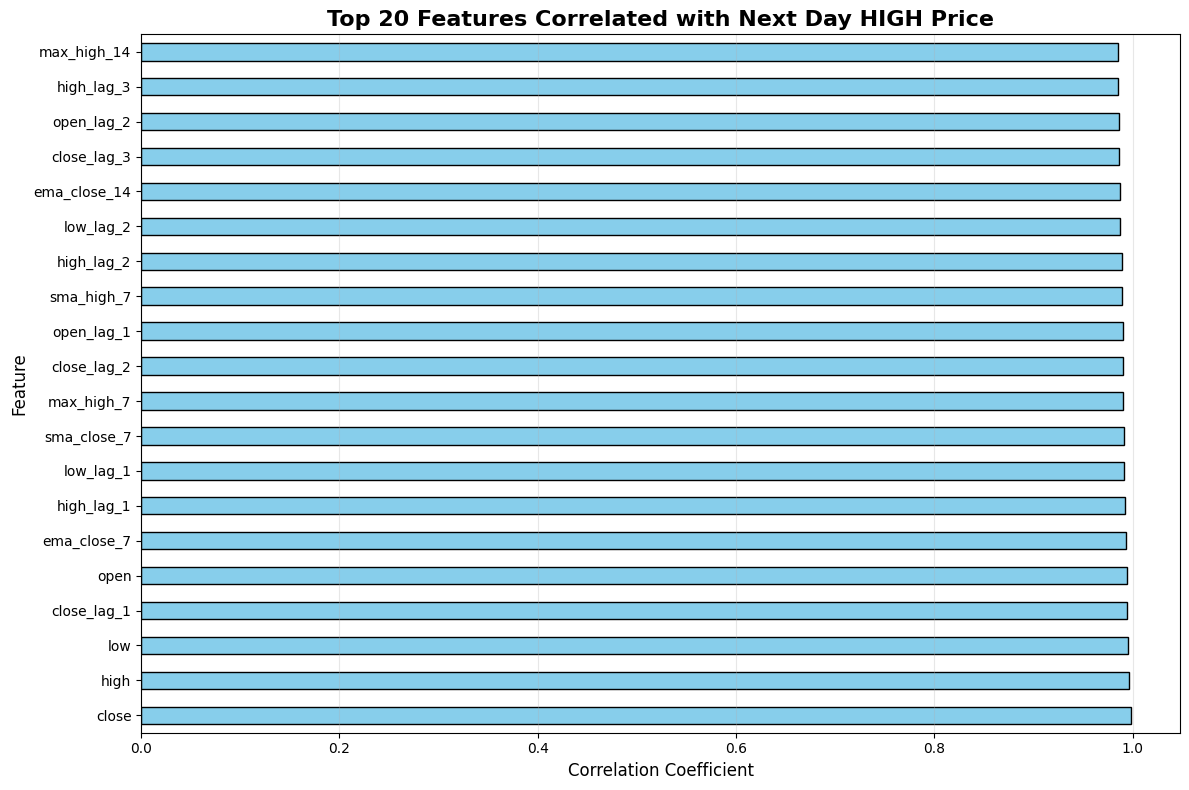


✓ As expected, recent prices (high, close, lag_1) are most correlated with next day's HIGH


In [16]:
# Visualize top correlations
top_features = correlations.head(21)[1:]  # Exclude target itself

plt.figure(figsize=(12, 8))
top_features.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 20 Features Correlated with Next Day HIGH Price', fontsize=16, fontweight='bold')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ As expected, recent prices (high, close, lag_1) are most correlated with next day's HIGH")

## 13. Save Engineered Features

In [17]:
import os

# Create processed data directory
os.makedirs('../data/processed', exist_ok=True)

# Save the engineered features
output_file = '../data/processed/bitcoin_features_engineered.csv'
df_clean.to_csv(output_file, index=False)

# Also save as parquet for efficiency
output_parquet = '../data/processed/bitcoin_features_engineered.parquet'
df_clean.to_parquet(output_parquet, index=False)

print("="*70)
print("✓ FEATURE ENGINEERING COMPLETE!")
print("="*70)
print(f"\nData saved to:")
print(f"  CSV: {output_file}")
print(f"  Parquet: {output_parquet}")
print(f"\nFinal dataset shape: {df_clean.shape}")
print(f"  Rows: {df_clean.shape[0]}")
print(f"  Features: {df_clean.shape[1]}")
print(f"  Date range: {df_clean['timestamp'].min().date()} to {df_clean['timestamp'].max().date()}")

# Save feature list for reference
feature_list = [col for col in df_clean.columns if col not in original_cols]
with open('../data/processed/feature_list.txt', 'w') as f:
    f.write("Engineered Features\n")
    f.write("="*50 + "\n\n")
    for i, feature in enumerate(feature_list, 1):
        f.write(f"{i}. {feature}\n")

print(f"\n✓ Feature list saved to: ../data/processed/feature_list.txt")

✓ FEATURE ENGINEERING COMPLETE!

Data saved to:
  CSV: ../data/processed/bitcoin_features_engineered.csv
  Parquet: ../data/processed/bitcoin_features_engineered.parquet

Final dataset shape: (631, 125)
  Rows: 631
  Features: 125
  Date range: 2024-02-01 to 2025-10-23

✓ Feature list saved to: ../data/processed/feature_list.txt
